In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, cmath
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, state_visualization
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city 
import qis401

### Toffoli Gates in Qiskit 

Toffoli gates are added to a circuit using the <code>ccx(control1, control2, target)</code> method.

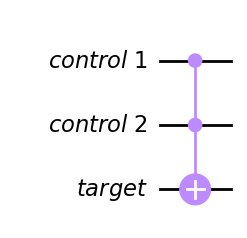

In [2]:
control1 = QuantumRegister(1, "control 1")
control2 = QuantumRegister(1, "control 2")
target = QuantumRegister(1, "target")
circ = QuantumCircuit(control1, control2, target)
circ.ccx(control1, control2, target)
circ.draw('mpl')

### NOT, AND, OR using Quantum Toffolis

First observe that since a NOT gate only takes in a single input, this translates to using just a standard CX gate. The function <code>quantum_not(circ, a, result)</code> adds this circuit the QuantumCircuit parameter <code>circ</code>.

In [3]:
def quantum_not(circ, a, result):
    ''' 
    Adds a quantum NOT gate that to the QuantumCircuit circ
    that NOTs quibit a and stores the result on qubit result.
    '''
    circ.cx(a, result)

Keep in mind a more direct way of computing NOT on a quantum circuit is to just use an X gate. However the purpose of this exercise is to see how Toffolis are universal (and to give you practice working with ancilla qubits). Therefore, we will only utilize CX and CCX gates. 

Next, we have functions that implement AND and OR gates using Toffolis:

In [4]:

def quantum_and(circ, a, b, nand_result, result):
    ''' 
    Adds a quantum AND gate that to the QuantumCircuit circ.
    @return the final output is stored on the qubit result. 
    We also pass in an extra "ancilla" qubit nand_result that is used to store the 
    answer of the first NAND before passiing it along to the quantum_not() function. 
    Also note that we assume the nand_result ancilla is set to state |1> at the outset. 
    '''
    circ.ccx(a, b, nand_result) 
    quantum_not(circ, nand_result, result)
    
def quantum_or(circ, a, b, a_not_result, b_not_result, result):
    '''
    Implements an OR gate using a similar approach to quantum_and().
    We now need two ancilla qubits to store the result of both NOTs.
    '''
    quantum_not(circ, a, a_not_result)
    quantum_not(circ, b, b_not_result)
    circ.ccx(a_not_result, b_not_result, result)

### Practice Exercise: Quantum Half Adder

#### Part 1: Implement Quantum XOR
Using a similar approach to the functions <code>quantum_not()</code>, <code>quantum_and()</code>, and <code>quantum_or()</code>, write a function called <code>quantum_xor()</code> that adds the quantum version of an XOR gate to a QuantumCircuit object. 

As in the functions above, the first parameter should be the QuantumCircuit itself. The next two parameters correspond to the input qubits <code>a</code> and <code>b</code>, and then the last qubit should store the result. You will need to decide which/how many ancilla qubits to include as parameters in order to correctly “link up” the circuit.  

In [5]:
def quantum_xor(circ, a, b, ab_nand_result, ab_or_ancilla_1, ab_or_ancilla_2, ab_or_result, and_ancil, result):
    ''' 
    Adds an XOR gate to circuit circ, that computes a XOR b and stores the result on result.
    Five additional ancillas are included to store intermediate results. 
    '''
    circ.ccx(a, b, ab_nand_result)
    circ.barrier()
    quantum_or(circ, a, b, ab_or_ancilla_1, ab_or_ancilla_2, ab_or_result)
    circ.barrier()
    quantum_and(circ, ab_or_result, ab_nand_result, and_ancil, result)

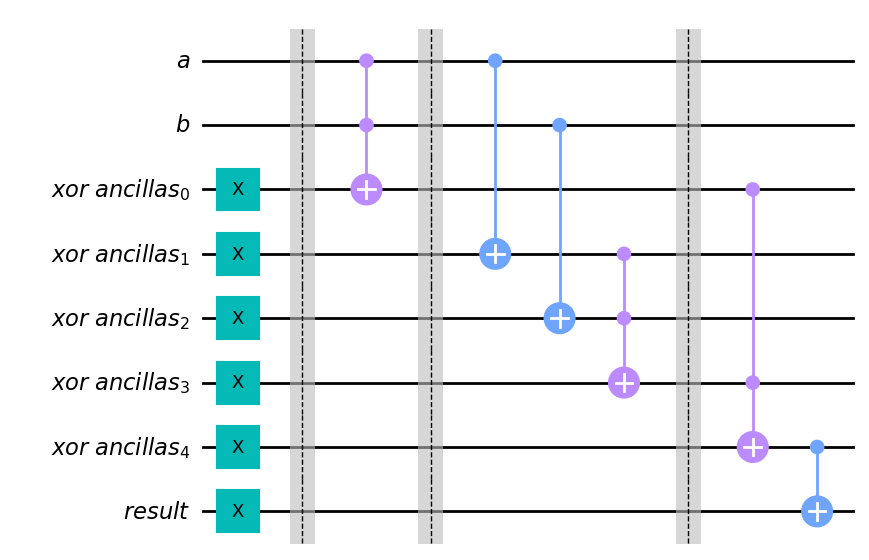

In [6]:
# drawing xor circuit
a = QuantumRegister(1, 'a')
b = QuantumRegister(1, 'b')
ancil = QuantumRegister(5, 'xor ancillas')
result = QuantumRegister(1, 'result')
circ = QuantumCircuit(a, b, ancil, result)

# ancills an result need to start as 1s 
circ.x(ancil)
circ.x(result)
circ.barrier()

# add xor circuit
quantum_xor(circ, a, b, ancil[0], ancil[1], ancil[2], ancil[3], ancil[4], result)
circ.draw('mpl')

#### Part 2: Implement Quantum Half Adder 

Using the gate functions above, write a function called <code>make_adder_circ(a, b)</code> that takes in two ints <code>a</code> and <code>b</code> that are either 0 or 1, and then returns a QuantumCircuit object implementing a half adder circuit the outputs the result of <code>a</code>+<code>b</code>.

Note that you are allowed to use as many qubits as you like in the circuit, but the last two qubits should store the sum and carry bits, respectively (e.g., if the sum and carry should be 1 and 0, respectively, then the 2nd to last qubit should be in state $|1\rangle$ and the last qubit should be in state $|0\rangle$). This is the only assumption made by the function <code>quantum_half_adder(a, b)</code>, which can be used to test your implementation. 

In [7]:
def make_adder_circ(a, b):
    '''
    Creates a quantum circuit that computes the result of adding two bits.
    
    Args:
        Two ints a and b (either 0 or 1)
    Returns: 
        QuantumCircuit object that implements a half adder.
        @return 2nd to last and last qubits store the sum and carry results. 
    '''
    
    # construct the circuit
    a_reg = QuantumRegister(1, 'a')
    b_reg = QuantumRegister(1, 'b')
    xor_ancils = QuantumRegister(5, 'xor_ancil')
    and_ancil = QuantumRegister(1, 'and_ancil')
    sum_reg = QuantumRegister(1, 'sum')
    carry_reg = QuantumRegister(1, 'carry')
    circ = QuantumCircuit(a_reg, b_reg, xor_ancils, and_ancil, sum_reg, carry_reg)
    
    # set a and b qubits according the parameters
    if a: circ.x(a_reg)
    if b: circ.x(b_reg)
    
    # put ancillas in state |1>
    circ.x(xor_ancils)
    circ.x(and_ancil)
    circ.x(sum_reg)
    circ.x(carry_reg)
    circ.barrier()
    
    # implements half adder circuit
    quantum_xor(circ, a_reg, b_reg, xor_ancils[0], xor_ancils[1], xor_ancils[2], xor_ancils[3],  xor_ancils[4], sum_reg)
    quantum_and(circ, a_reg, b_reg, and_ancil, carry_reg)
    
    return circ
    
def quantum_half_adder(a, b):
    ''' 
    Compute the sum of two bits
    
    Args: ints a and b (either 0 or 1)
    Returns: tuple (sum, carry)
    '''
    circ = make_adder_circ(a, b)
    result = qis401.simulate_circuit(circ, 1)
    output = list(result.get_counts().keys())[0]
    return (int(output[1]), int(output[0]))

In [8]:
assert quantum_half_adder(0, 0) == (0, 0)
assert quantum_half_adder(0, 1) == (1, 0)
assert quantum_half_adder(1, 0) == (1, 0)
assert quantum_half_adder(1, 1) == (0, 1)

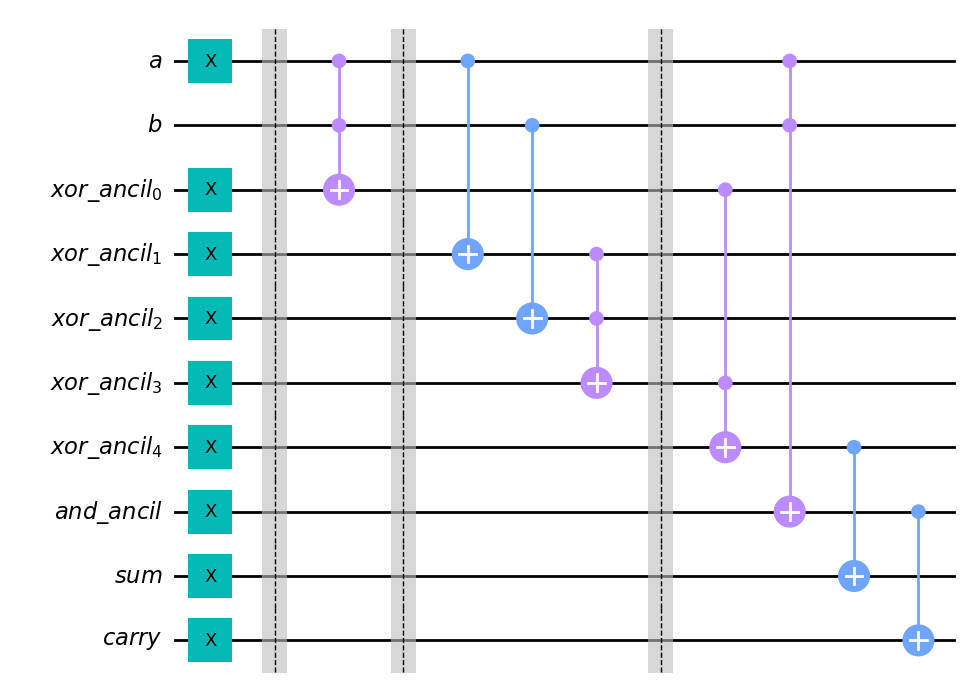

In [9]:
circ = make_adder_circ(1, 0)
circ.draw('mpl')